In [1]:
import sympy as sm
import sympy.physics.mechanics as me
import time
import numpy as np
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import fsolve, minimize
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import pythreejs as p3js

In [2]:
start = time.time()
#==========================================================================
n = 3                   # number of pendulum bodies, labelled 0, 1, .., n-1, must be two ore more.
#==========================================================================


m, m1, g, r, l, reibung, k, t = sm.symbols('m, m1, g, r, l, reibung, k, t')
iXX, iYY, iZZ = sm.symbols('iXX, iYY, iZZ')

q = []     #holds the generalized coordinates of each rod
u = []     # generalized angular speeds


A = []     # frames of each rod

Dmc = []   # geometric center of each body
P = []     # points at end of each rod. Dmc_i is between P_i and P_i+1
punkt = [] # marks a red dot on each ball, just used for animation

for i in range(n):
    for j in ('x', 'y', 'z'):
        q.append(me.dynamicsymbols('q' + j + str(i)))
        u.append(me.dynamicsymbols('u' + j + str(i)))

    A.append(me.ReferenceFrame('A' + str(i)))
    Dmc.append(me.Point('Dmc' + str(i)))
    P.append(me.Point('P' + str(i)))
    punkt.append(me.Point('punkt' + str(i)))


N = me.ReferenceFrame('N')        # inertial frame
P0 = me.Point('P0')

# set up the relevant frames, one for each body
rot = []      # for kinetatic equations
rot1 = []     # dto

A[0].orient_body_fixed(N, (q[0], q[1], q[2]), '123')
rot.append(A[0].ang_vel_in(N))
# it is VERY important, that the angular speed be expressed in therms of the 'child frame', otherwise
# the equations of motion become very large!
A[0].set_ang_vel(N, u[0]*A[0].x + u[1]*A[0].y + u[2]*A[0].z )
rot1.append(A[0].ang_vel_in(N))


for i in range(1, n):
    A[i].orient_body_fixed(A[i-1], (q[3*i], q[3*i+1],q[3*i+2]), '123')
    rot.append(A[i].ang_vel_in(N))             # needed for the kinematiic equations below
# it is VERY important, that the angular speed be expressed in therms of the 'child frame', otherwise
# the equations of motion become very large!
    A[i].set_ang_vel(N, u[3*i]*A[i].x + u[3*i+1]*A[i].y + u[3*i+2]*A[i].z)
    rot1.append(A[i].ang_vel_in(N))            #         dto.


# locate the various points, and define their speeds
P[0].set_pos(P0, 0.)
P[0].set_vel(N, 0.)             # fixed point
Dmc[0].set_pos(P[0], l/2. * A[0].y)
Dmc[0].v2pt_theory(P[0], N, A[0])
punkt[0].set_pos(Dmc[0], r*A[0].z)             # only for the red dot in the animation
punkt[0].v2pt_theory(Dmc[0], N, A[0])

for i in range(1, n):
    P[i].set_pos(P[i-1], l * A[i-1].y)
    P[i].v2pt_theory(P[i-1], N, A[i-1])
    Dmc[i].set_pos(P[i], l/sm.S(2.) * A[i].y)
    Dmc[i].v2pt_theory(P[i], N, A[i])
    punkt[i].set_pos(Dmc[i], r*A[i].z)
    punkt[i].v2pt_theory(Dmc[i], N, A[i])


# make the list of the bodies
BODY = []
for i in range(n):
    I = me.inertia(A[i], iXX, iYY, iZZ)
    BODY.append(me.RigidBody('body' + str(i), Dmc[i], A[i], m, (I, Dmc[i])))
    BODY.append(me.Particle('punct' + str(I), punkt[i], m1))  # the red dot may have a mass


# set up the forces
# weights
FG = [(Dmc[i], -m*g*N.y) for i in range(n)] + [(punkt[i], -m1*g*N.y) for i in range(n)]

# when the balls collide, they are ideally elastic, with 'spring constant' k. They are also completely
# slick, so collisions will not affect their rotational speeds
FB = []
for i in range(n):
    for j in range(i+1, n):
        aa = Dmc[j].pos_from(Dmc[i])
        bb = aa.magnitude()
        aa = aa.normalize()
        forceij = (Dmc[j],  k * (2*r - bb) * aa * sm.Heaviside(2.*r - bb))
        FB.append(forceij)
        forceji = (Dmc[i], -k * (2*r - bb) * aa * sm.Heaviside(2.*r - bb))
        FB.append(forceji)

FL = FG + FB       # list of forces

# kinematic equations
kd = []
for i in range(n):
# It is very important that below the frames A[i] be used, not N. Otherwise the equations of motion become very large.
    for uv in A[i]:
        kd.append(me.dot(rot[i] - rot1[i], uv))

# Kanes's equations
q1 = q
u1 = u

KM = me.KanesMethod(N, q_ind=q1, u_ind=u1, kd_eqs=kd)
(fr, frstar) = KM.kanes_equations(BODY, FL)

MM = KM.mass_matrix_full
print('MM DS', me.find_dynamicsymbols(MM))
print('MM free symbols', MM.free_symbols)
print('MM contains {} operations'.format(sum([MM[i, j].count_ops(visual=False)
        for i in range(MM.shape[0]) for j in range(MM.shape[1])])), '\n')

force = KM.forcing_full
print('force DS', me.find_dynamicsymbols(force))
print('force free symbols', force.free_symbols)
print('force contains {} operations'.format(sum([force[i].count_ops(visual=False)
        for i in range(force.shape[0])])), '\n')

# set up the energy equations. Absent ary friction the total energie should be cnstant
pot_energie = sum([m*g*me.dot(Dmc[i].pos_from(P[0]), N.y) for i in range(n)]) + sum([m1*g*me.dot(punkt[i]
                        .pos_from(P[0]), N.y) for i in range(n)])
kin_energie = sum([BODY[i].kinetic_energy(N) for i in range(2*n)])
spring_energie = sm.S(0.)
for i in range(n):
    for j in range(i+1, n):
        aa = Dmc[j].pos_from(Dmc[i])
        bb = aa.magnitude()
        aa = aa.normalize()
        spring_energie  += 0.5 * k * (2*r - bb)**2 * sm.Heaviside(2.*r - bb)


# position of the centers of the balls and the red dots on the ball. Needed for the animation
Dmc_loc = []
punkt_loc = []
for i in range(n):
    Dmc_loc.append([me.dot(Dmc[i].pos_from(P[0]), uv) for uv in N])
    punkt_loc.append([me.dot(punkt[i].pos_from(P[0]), uv) for uv in N])

# Lambdification
qL = q1 + u1
pL = [m, m1, g, r, l, iXX, iYY, iZZ, reibung, k]

MM_lam = sm.lambdify(qL + pL, MM, cse=True)
force_lam = sm.lambdify(qL + pL, force, cse=True)

pot_lam = sm.lambdify(qL + pL, pot_energie, cse=True)
kin_lam = sm.lambdify(qL + pL, kin_energie, cse=True)
spring_lam = sm.lambdify(qL + pL, spring_energie, cse=True)

Dmc_loc_lam = sm.lambdify(qL + pL, Dmc_loc, cse=True)
punkt_loc_lam = sm.lambdify(qL + pL, punkt_loc, cse=True)

print('it took {:.3f} sec to set up Kanes equations'.format(time.time() - start))

MM DS {qy1(t), qy2(t), qz1(t), qx2(t), qx1(t), qz2(t)}
MM free symbols {r, t, iYY, iZZ, m, l, iXX, m1}
MM contains 2067 operations 

force DS {uy1(t), qx2(t), qx1(t), ux2(t), qy2(t), qx0(t), uz2(t), ux0(t), uz0(t), qz1(t), uy2(t), uy0(t), qy1(t), qy0(t), uz1(t), ux1(t), qz0(t), qz2(t)}
force free symbols {r, iYY, k, iZZ, l, iXX, g, t, m, m1}


force contains 12061 operations 



it took 5.957 sec to set up Kanes equations


In [3]:
# numerical integration
start = time.time()

# Input values
#=====================================================================
r1 = 1.5                                 # radius of the ball
m1 = 1.                                  # mass of the ball
m11 = m1 / 5.                            # mass of the red dot
l1 = 6.                                  # length of the massless rod of the pendulum
k1 = 1000.                               # 'spring constant' of the balls
reibung1 = 0.                            # friction of the ball against the rod

q1x, q1y, q1z = 0.2, 0.2, 0.2            # initial deflection of the first rod
                                         # for simplicity, I assume that the pendulum is straight initially

omega1 = 7.5                             # initial rotation speed of ball_i around A[i].y
u1x, u1y, u1z = 0., omega1, 0.           # initial rotational speed of the ball

intervall = 2.
#======================================================================
schritte = 100 * int(intervall)
times = np.linspace(0., intervall, schritte)
iXX1 = 2./5. * m1 * r1**2                # from the internet
iYY1 = iXX1
iZZ1 = iXX1

#pL = [m, g, r, l, iXX, iYY, iZZ, reibung, k]
pL_vals = [m1, m11, 9.8, r1, l1, iXX1, iYY1, iZZ1, reibung1, k1]

y0 = [q1x, q1y, q1z] + [0., 0., 0.] * (n-1) + [u1x, u1y, u1z] + [0. ,u1y, 0.] * (n-1)
print('Starting values: ', y0)

t_span = (0., intervall)

def gradient(t, y, args):
    sol = np.linalg.solve(MM_lam(*y, *args), force_lam(*y, *args))
    return np.array(sol).T[0]

resultat1 = solve_ivp(gradient, t_span, y0, t_eval = times, args=(pL_vals,), method='Radau')

resultat = resultat1.y.T
print('shape of resultat', resultat.shape)
event_dict = {-1: 'Integration failed', 0: 'Integration finished successfully', 1: 'some termination event'}
print(event_dict[resultat1.status])
print("To numerically integrate an intervall of {:.3f} sec the routine cycled {} times and it took {:.3f} sec"
      .format(intervall, resultat1.nfev, time.time() - start))

Starting values:  [0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 7.5, 0.0, 0.0, 7.5, 0.0]


shape of resultat (200, 18)
Integration finished successfully
To numerically integrate an intervall of 2.000 sec the routine cycled 826 times and it took 1.059 sec


deviation of total energy from being constant is 0.03864 % of max. total energy


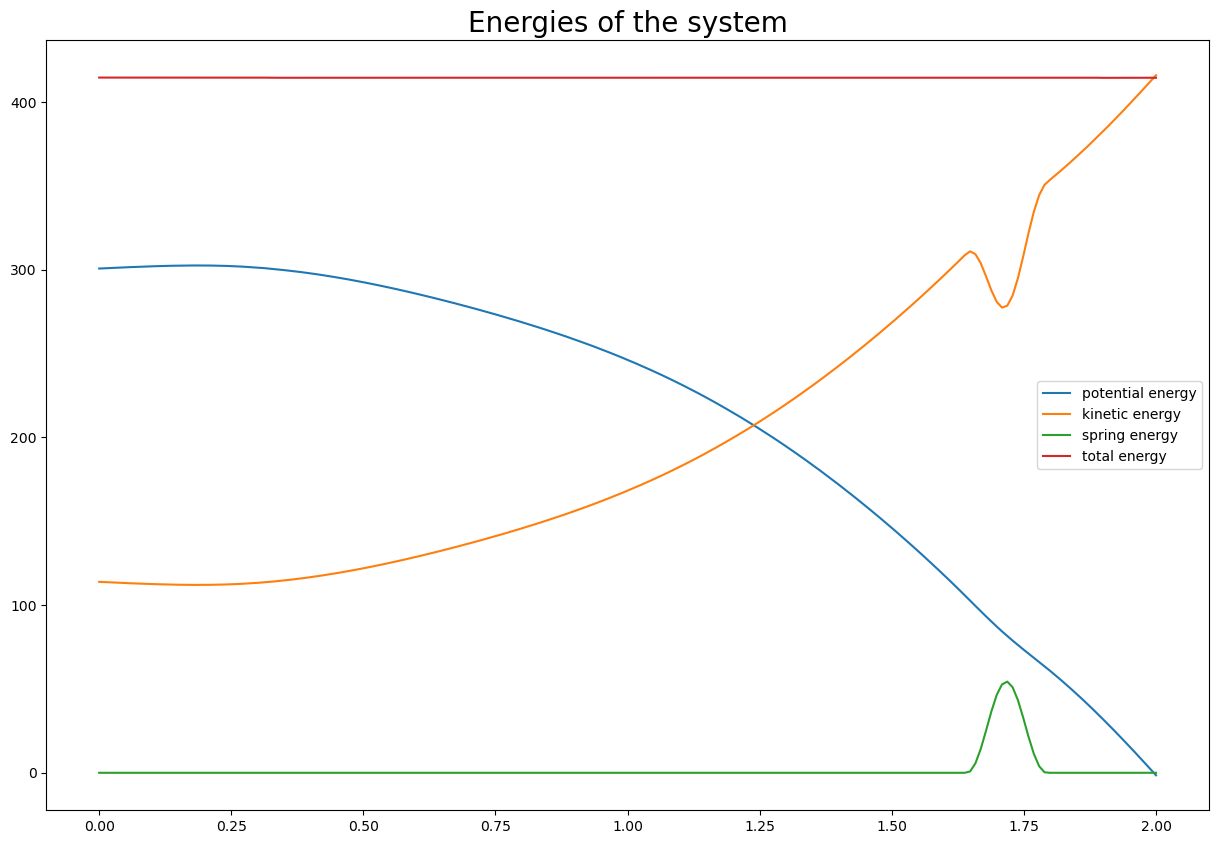

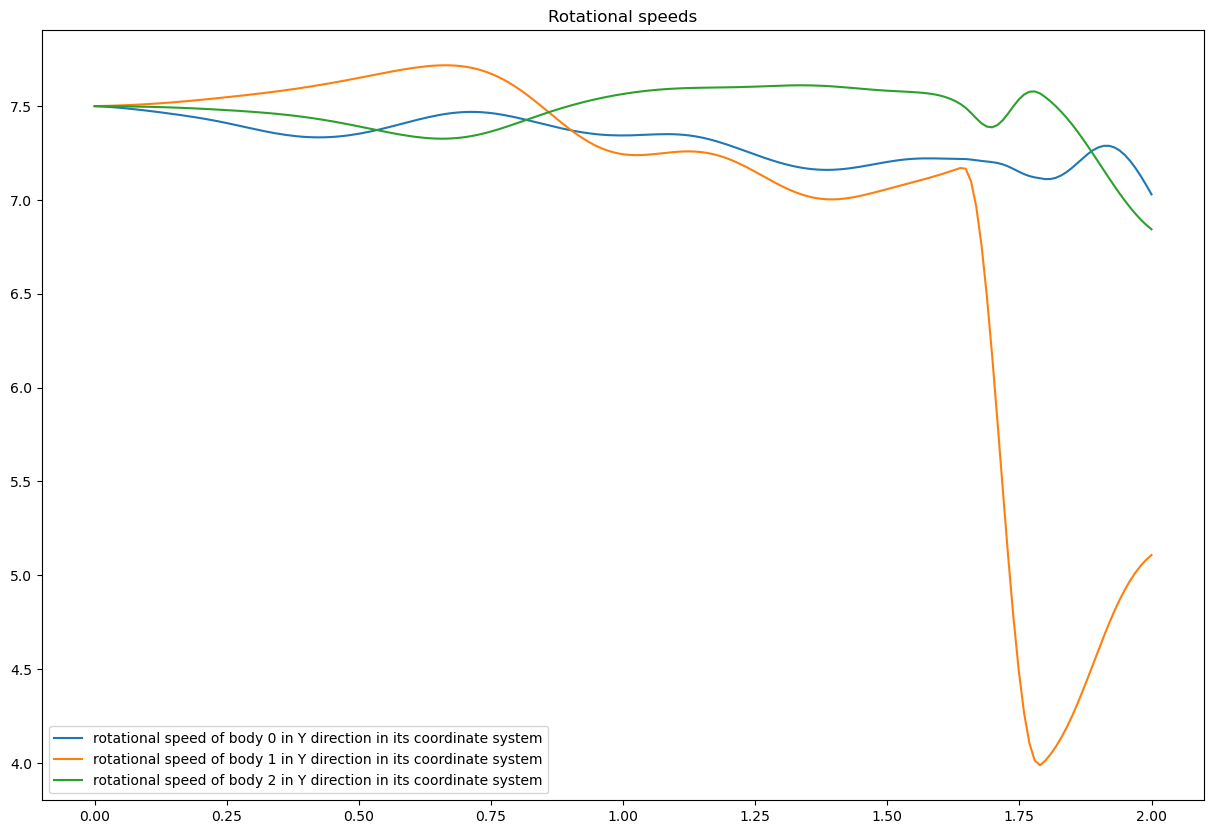

In [4]:
# plot the energies

pot_np = np.empty(schritte)
kin_np = np.empty(schritte)
spring_np = np.empty(schritte)
total_np = np.empty(schritte)

for i in range(schritte):
    zeit = times[i]
    pot_np[i] = pot_lam(*[resultat[i, j] for j in range(resultat.shape[1])], *pL_vals)
    kin_np[i] = kin_lam(*[resultat[i, j] for j in range(resultat.shape[1])], *pL_vals)
    spring_np[i] = spring_lam(*[resultat[i, j] for j in range(resultat.shape[1])], *pL_vals)
    total_np[i] = pot_np[i] + kin_np[i] + spring_np[i]

if reibung1 == 0.:
    total_max = np.max(total_np)
    total_min = np.min(total_np)
    print('deviation of total energy from being constant is {:.5f} % of max. total energy'
          .format((total_max - total_min)/total_max*100) )

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(times, pot_np, label='potential energy')
ax.plot(times, kin_np, label='kinetic energy')
ax.plot(times, spring_np, label='spring energy')
ax.plot(times, total_np, label='total energy')
ax.set_title('Energies of the system', fontsize=20)
ax.legend();

#plot the main rotational speeds, uy_r
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(n, 2*n):
    ax.plot(times, resultat[:, 3*i+1],
        label='rotational speed of body {} in Y direction in its coordinate system'.format(i-n))
ax.set_title('Rotational speeds')
ax.legend();

In [5]:
winkel = sm.symbols('winkel')
Rotation1 = sm.Matrix([[sm.cos(winkel), -sm.sin(winkel), 0], [sm.sin(winkel), sm.cos(winkel), 0], [0., 0., 1]])
Rot_lam = sm.lambdify(winkel, Rotation1.T, cse=True)
Rotation = Rot_lam(np.pi/2.)

TC_store = []
TR_store = []
TP_store = []
body_mesh_store = []
track_store = []
farben = ['orange', 'blue', 'green', 'yellow', 'red']
for i in range(n):
#for its mass center
    TC = sm.eye(4)
    TC[:3, :3] = (A[i].dcm(N)) * Rotation
    TC = TC.reshape(16, 1)
    TC_lam = sm.lambdify(qL + pL, TC, cse=True)

    TR = sm.eye(4)
    TR[:3, :3] = (A[i].dcm(N)) * Rotation
    TR = TR.reshape(16, 1)
    TR_lam = sm.lambdify(qL + pL, TR, cse=True)

    TP = sm.eye(4)
    TP[:3, :3] = (A[i].dcm(N)) * Rotation
    TP = TP.reshape(16, 1)
    TP_lam = sm.lambdify(qL + pL, TP, cse=True)


# store the information about the body, expressed in TAc for every time step.
    TCs = []   # for the ball
    TRs = []   # for the rod
    TPs = []   # for the red dot

# Create the TAs, containing 'one TA' for each time step
# resultat contains the results of the numeric integration.
# where the numeric integration was evaluated
# scala is the factor by which the position of the body is changed, to keep it on the screen.
    scala = 1.
    for k in range(resultat.shape[0]):
        zeit = times[i]
        TCi = TC_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)  # the balls
        TRi = TR_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)  # the rod
        TPi = TP_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)  # the dot

# TAi[12], TAi[13], TAi[14] hold the location of A2 w.r.t. N.
# As the axis chosen for solving the equations of motion, and the axis given by pythreejs do not
# coincide, the values for TAi[..] must be given accordingly.
# of course here different locations for center of ball and center of mass.
        TRi[12] = -Dmc_loc_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)[i][1]
        TRi[13] = Dmc_loc_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)[i][0] / scala
        TRi[14] = Dmc_loc_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)[i][2] / scala

        TCi[12] = -Dmc_loc_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)[i][1]
        TCi[13] = Dmc_loc_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)[i][0] / scala
        TCi[14] = Dmc_loc_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)[i][2] / scala

        TPi[12] = -punkt_loc_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)[i][1]
        TPi[13] = punkt_loc_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)[i][0] / scala
        TPi[14] = punkt_loc_lam(*[resultat[k, l] for l in range(resultat.shape[1])], *pL_vals)[i][2] / scala

        TRs.append(TRi.squeeze().tolist())
        TCs.append(TCi.squeeze().tolist())
        TPs.append(TPi.squeeze().tolist())

    TC_store.append(TCs)
    TR_store.append(TRs)
    TP_store.append(TPs)

# Create the objects, which will move
# 1. The ball
    body_geom_C = p3js.SphereGeometry(r1, 12, 12)
    body_material_C = p3js.MeshStandardMaterial(color=farben[i], wireframe=False)
    body_mesh_C = p3js.Mesh(geometry=body_geom_C, material=body_material_C, name='ball_' + str(i))

# 2. Rod
    body_geom_R = p3js.CylinderGeometry(radiusTop=0.05, radiusBottom=0.05, height=l1,
                    radialSegments=6, heightSegments=10, openEnded=False)
    body_material_R = p3js.MeshStandardMaterial(color='black', wireframe=False)
    body_mesh_R = p3js.Mesh(geometry=body_geom_R, material=body_material_R, name='rod_' + str(i))

# 3. the dot
    body_geom_P = p3js.SphereGeometry(0.25, 12, 12)
    body_material_P = p3js.MeshStandardMaterial(color='red', wireframe=False)
    body_mesh_P = p3js.Mesh(geometry=body_geom_P, material=body_material_P, name='punkt_' + str(i))

# locate the body in 3D space and add the coordinate system of the body
    body_mesh_R.matrixAutoUpdate = False
    body_mesh_R.add(p3js.AxesHelper(0.1))  # length of the axis of the ball system A2
    body_mesh_R.matrix = TR_store[i][0]             # starting point of the animation

    body_mesh_C.matrixAutoUpdate = False
    body_mesh_C.add(p3js.AxesHelper(0.01))    # length of the axis of the center of mass system A2
    body_mesh_C.matrix = TC_store[i][0]          # starting point of the animation

    body_mesh_P.matrixAutoUpdate = False
    body_mesh_P.add(p3js.AxesHelper(0.01))    # length of the axis of the center of mass system A2
    body_mesh_P.matrix = TP_store[i][0]          # starting point of the animation


    body_mesh_store.append(body_mesh_C)
    body_mesh_store.append(body_mesh_R)
    body_mesh_store.append(body_mesh_P)


# Create the 'picture'.
# all the 'paramters' are taken by trial and error.
view_width = 1200
view_height = 400

# Values just found by trial an error.
if n == 3:
    p1, p2 = 7, 7
    p3 = 35
elif n == 4:
    p1, p2 = 5, 5
    p3 = 50
elif n == 5:
    p1, p2 = 5, 5
    p3 = 65
else:
    p1, p2 = 5, 5
    p3 = 25
camera = p3js.PerspectiveCamera(position=[p1, p2, p3],
                                up=[-1.0, 0.0, 0.0],
                                aspect=view_width/view_height)

key_light = p3js.DirectionalLight(position=[0, 0, 10])
ambient_light = p3js.AmbientLight()

axes = p3js.AxesHelper(20)
print(p1, p2, p3)
children = []
for i in range(3*n):
    children = children + [body_mesh_store[i], axes, camera, key_light, ambient_light]

scene = p3js.Scene(children=children)
controller = p3js.OrbitControls(controlling=camera)
renderer = p3js.Renderer(camera=camera, scene=scene, controls=[controller],
                         width=view_width, height=view_height)

# Create the action, simply copied from JM's lecture.

for i in range(n):
    eigenname = 'ball_'+str(i)
    track_C = p3js.VectorKeyframeTrack(
        name="scene/" + eigenname + ".matrix",
        times=times,
        values=TC_store[i])

    eigenname = 'rod_' + str(i)
    track_R = p3js.VectorKeyframeTrack(
        name="scene/" + eigenname + ".matrix",
        times=times,
        values=TR_store[i])

    eigenname = 'punkt_' + str(i)
    track_P = p3js.VectorKeyframeTrack(
        name="scene/" + eigenname + ".matrix",
        times=times,
        values=TP_store[i])

    track_store += [track_C] + [track_R] + [track_P]

duration = times[-1] - times[0]
clip = p3js.AnimationClip(tracks=track_store, duration=duration)
action = p3js.AnimationAction(p3js.AnimationMixer(scene), clip, scene)
renderer

7 7 35


/home/docs/checkouts/readthedocs.org/user_builds/pydy/conda/stable/lib/python3.8/site-packages/pythreejs/traits.py:257: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=3.0, position=(7.0, 7.0, 35.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0,…

In [6]:
action

AnimationAction(clip=AnimationClip(duration=2.0, tracks=(VectorKeyframeTrack(name='scene/ball_0.matrix', times…